SETUP

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
import qkeras
from qkeras import *

In [2]:
X = np.load("/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/bnb_WithWire_00_batch_0_10X64.npy")

In [3]:
X.shape

(20480, 54, 64, 1)

In [4]:
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

In [5]:
#model = keras.models.load_model("noQDB_seq", custom_objects=co)
teacher = keras.models.load_model('/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/Seokju_Models/teacher_tiles10X64_full17')
student_test = qkeras.utils.load_qmodel('/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/Seokju_Models/Cicada3_tiles10X64')

In [6]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 teacher_inputs_ (InputLaye  [(None, 54, 64, 1)]       0         
 r)                                                              
                                                                 
 teacher_reshape (Reshape)   (None, 54, 64, 1)         0         
                                                                 
 teacher_conv2d_1 (Conv2D)   (None, 54, 64, 20)        200       
                                                                 
 teacher_relu_1 (Activation  (None, 54, 64, 20)        0         
 )                                                               
                                                                 
 teacher_pool_1 (AveragePoo  (None, 27, 32, 20)        0         
 ling2D)                                                         
                                                           

In [7]:
student_test.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 3456)]            0         
                                                                 
 reshape (Reshape)           (None, 54, 64, 1)         0         
                                                                 
 conv (QConv2D)              (None, 27, 32, 4)         16        
                                                                 
 relu0 (QActivation)         (None, 27, 32, 4)         0         
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense1 (QDense)             (None, 16)                55296     
                                                                 
 relu1 (QActivation)         (None, 16)                0 

In [8]:
import hls4ml
import QDenseBatchnorm


In [9]:
config = hls4ml.utils.config_from_keras_model(student_test, backend='Vitis', 
                                              default_precision='fixed<32,16>',
                                              granularity='name')

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 3456]], output shape: [None, 3456]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 3456]], output shape: [None, 54, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 54, 64, 1]], output shape: [None, 27, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 27, 32, 4]], output shape: [None, 27, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 27, 32, 4]], output shape: [None, 3456]
Layer name: dense1, layer type: QDense, input shapes: [[None, 3456]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]


/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

In [11]:
config

{'Model': {'Precision': 'fixed<32,16>',
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'inputs_': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>'}},
  'reshape': {'Trace': True, 'Precision': {'result': 'fixed<32,16>'}},
  'conv': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>',
    'weight': 'fixed<16,5>',
    'bias': 'fixed<32,16>',
    'accum': 'fixed<32,16>'},
   'ReuseFactor': 1,
   'ParallelizationFactor': 1,
   'ConvImplementation': 'LineBuffer'},
  'conv_linear': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>', 'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'relu0': {'Trace': True,
   'Precision': {'result': 'ufixed<10,4,RND_CONV,SAT>',
    'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'flatten': {'Trace': True, 'Precision': {'result': 'fixed<32,16>'}},
  'dense1': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>',
    'weight':

In [12]:
hls_model = hls4ml.converters.convert_from_keras_model(student_test,
                                                       hls_config=config,
                                                       io_type='io_parallel',
                                                       output_dir=f'cicada3_10x64_hls4mlproj')

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 3456]], output shape: [None, 3456]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 3456]], output shape: [None, 54, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 54, 64, 1]], output shape: [None, 27, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 27, 32, 4]], output shape: [None, 27, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 27, 32, 4]], output shape: [None, 3456]
Layer name: dense1, layer type: QDense, input shapes: [[None, 3456]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model


In [13]:
X_flat = X.reshape((20480,-1))

In [14]:
X_flat.shape

(20480, 3456)

In [15]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

ntimeticks = 6400
nwire = 3456
f_downsample = 10
h_split = 10
v_split = 4
nbatch = 32

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

adccutoff = 10.*f_downsample/10.
adcsaturation = 100.*f_downsample/10.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


COMPILING AND PREDICTING

In [17]:
#Y = student_test.predict(X_flat)

X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')
#X_student = X.reshape((-1,nwire*ntimeticks//f_downsample//v_split//h_split,1))
Y = student_test.predict(X_flat).reshape(len(X_loss_teacher))


640/640 [==============================] - 1s 2ms/step


In [18]:
hls_model.compile()

Writing HLS project


/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [19]:
fake_hls4ml_pred, hls4ml_trace = hls_model.trace(X)

Recompiling myproject with tracing
Writing HLS project
Done


In [20]:
#Y_hls = hls_model.predict(X_flat)
y_predict_hls4ml_q = hls_model.predict(X_flat).reshape(len(X_loss_teacher))


RESULTS

In [21]:
for j in Y:
    print(j)

0.0
0.0
0.0
36.101562
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
52.67578
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.5976562
0.0
0.0
0.0
0.0
5.640625
0.0
63.125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.1992188
0.0
0.0
39.945312
1.4140625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
120.40234
0.0
0.0
0.0
0.0
55.41797
0.0
0.0
0.0
0.0
3.8984375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
63.996094
3.1796875
0.0
17.054688
0.0
0.0
0.0
0.0
5.6875
0.0
0.0
0.0
0.0
0.0
0.0
12.15625
0.0
0.0
0.0
0.0
0.3359375
0.0
32.03125
0.25390625
0.0
0.0
0.0
0.0
0.0
35.08203
0.0
24.417969
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
165.39062
0.0
0.00390625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4375
0.0
0.0
0.0
109.00781
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.8085938
0.0
0.0
0.0
0.0
0.0
0.0
37.26172
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.4335938
0.0
0.0
0.0
0.0
0.0
0.

In [22]:
for i in y_predict_hls4ml_q:
    print(i)

0.0
0.0
0.0
35.83203
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
52.67578
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.6367188
0.0
0.0
0.0
0.0
5.6445312
0.0
62.90625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.0820312
0.0
0.0
39.94922
1.4140625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
120.17578
0.0
0.0
0.0
0.0
55.39453
0.0
0.0
0.0
0.0
3.8085938
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
63.996094
3.2460938
0.0
16.988281
0.0
0.0
0.0
0.0
5.6640625
0.0
0.0
0.0
0.0
0.0
0.0
12.15625
0.0
0.0
0.0
0.0
0.3359375
0.0
31.886719
0.25390625
0.0
0.0
0.0
0.0
0.0
34.972656
0.0
24.582031
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
165.29297
0.0
0.00390625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.4375
0.0
0.0
0.0
109.046875
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.8320312
0.0
0.0
0.0
0.0
0.0
0.0
36.914062
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.5507812
0.0
0.0
0.0
0.

In [23]:
import matplotlib.pyplot as plt

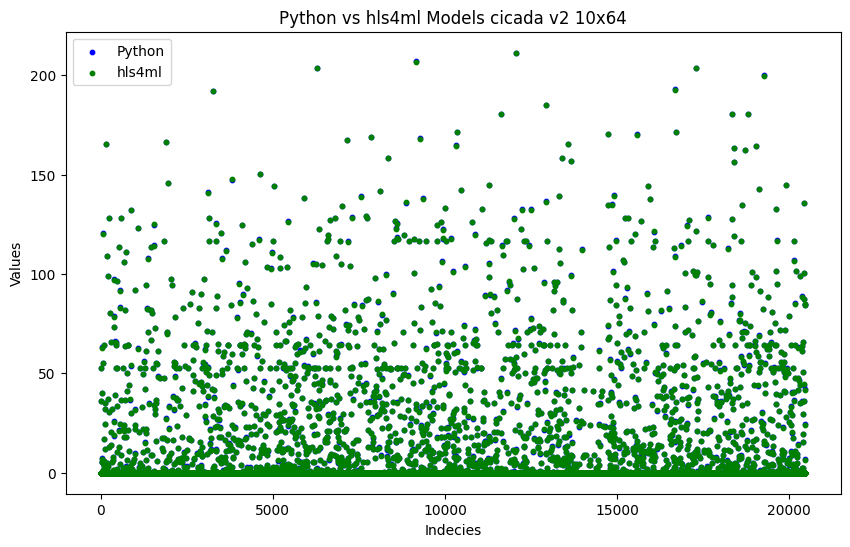

In [26]:
differences = [pred1 != pred2 for pred1, pred2 in zip(Y, y_predict_hls4ml_q)]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y)), Y, color='blue', s=10, label='Python')
plt.scatter(range(len(y_predict_hls4ml_q)), y_predict_hls4ml_q, color='green', s=10, label='hls4ml')

plt.xlabel('Indecies')
plt.ylabel('Values')
plt.title('Python vs hls4ml Models cicada v2 10x64')
plt.legend()
plt.show()
# Labels and title

In [25]:
off_list = np.argwhere(~np.isclose(Y, y_predict_hls4ml_q))

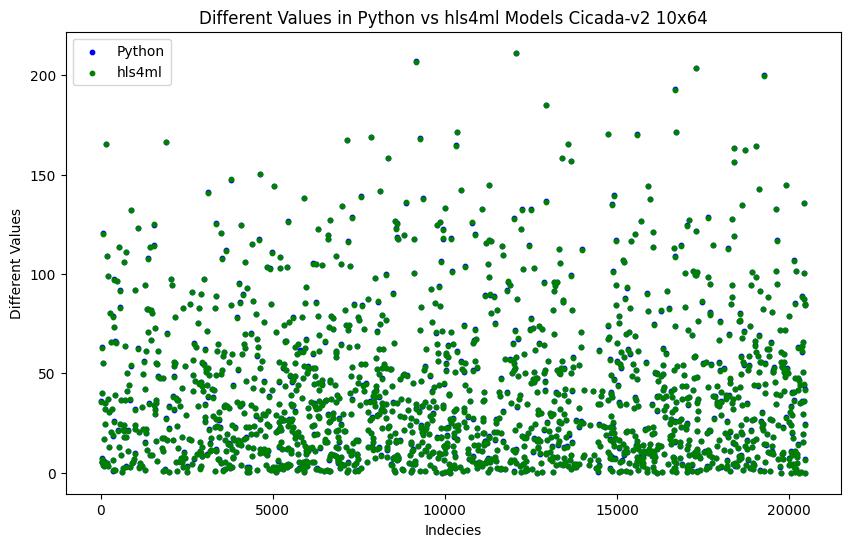

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(off_list, Y[off_list], color='blue', s=10, label='Python')
plt.scatter(off_list, y_predict_hls4ml_q[off_list], color='green', s=10, label='hls4ml')

plt.xlabel('Indecies')
plt.ylabel('Different Values')
plt.title('Different Values in Python vs hls4ml Models Cicada-v2 10x64')
plt.legend()
plt.show()

In [28]:
non_zero_list = np.argwhere(~np.isclose(0.0, y_predict_hls4ml_q))

In [29]:
len(off_list)

1695

In [30]:
len(non_zero_list)

2180

In [31]:
off_list_indexes = []
for k in off_list:
    off_list_indexes.append(k[0])

for ind in off_list_indexes:
    print("Y: ")
    print(Y[ind])
    print("hls pred: ")
    print(y_predict_hls4ml_q[ind])

Y: 
36.101562
hls pred: 
35.83203
Y: 
5.5976562
hls pred: 
5.6367188
Y: 
5.640625
hls pred: 
5.6445312
Y: 
63.125
hls pred: 
62.90625
Y: 
7.1992188
hls pred: 
7.0820312
Y: 
39.945312
hls pred: 
39.94922
Y: 
120.40234
hls pred: 
120.17578
Y: 
55.41797
hls pred: 
55.39453
Y: 
3.8984375
hls pred: 
3.8085938
Y: 
3.1796875
hls pred: 
3.2460938
Y: 
17.054688
hls pred: 
16.988281
Y: 
5.6875
hls pred: 
5.6640625
Y: 
32.03125
hls pred: 
31.886719
Y: 
35.08203
hls pred: 
34.972656
Y: 
24.417969
hls pred: 
24.582031
Y: 
165.39062
hls pred: 
165.29297
Y: 
109.00781
hls pred: 
109.046875
Y: 
4.8085938
hls pred: 
4.8320312
Y: 
37.26172
hls pred: 
36.914062
Y: 
3.4335938
hls pred: 
3.5507812
Y: 
99.0625
hls pred: 
98.74219
Y: 
12.921875
hls pred: 
12.855469
Y: 
30.625
hls pred: 
30.660156
Y: 
80.27344
hls pred: 
80.11328
Y: 
65.8125
hls pred: 
65.77734
Y: 
20.457031
hls pred: 
20.523438
Y: 
32.191406
hls pred: 
31.898438
Y: 
6.4023438
hls pred: 
6.3984375
Y: 
1.0664062
hls pred: 
1.359375
Y: 
78.6835

In [32]:
diff_sum=0
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    diff_sum=diff_sum+diff
diff_avg = diff_sum/len(off_list)
print(diff_avg)

0.13030742994100294


In [33]:
diff_pct = []
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    if Y[ind]==0:
        temp_diff_pct = diff
    else:
        temp_diff_pct = diff/Y[ind]
    diff_pct.append(temp_diff_pct)

In [34]:
diff_pct_avg = sum(diff_pct)/len(diff_pct)
print(diff_pct_avg)

0.011754458479175552


In [39]:
np.allclose(Y, y_predict_hls4ml_q, atol=1)

True

WEIGHTS

/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 3456]], output shape: [None, 3456]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 3456]], output shape: [None, 54, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 54, 64, 1]], output shape: [None, 27, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 27, 32, 4]], output shape: [None, 27, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 27, 32, 4]], output shape: [None, 3456]
Layer name: dense1, layer type: QDense, input shapes: [[None, 3456]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Profiling weights (before optimization)
Weights

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

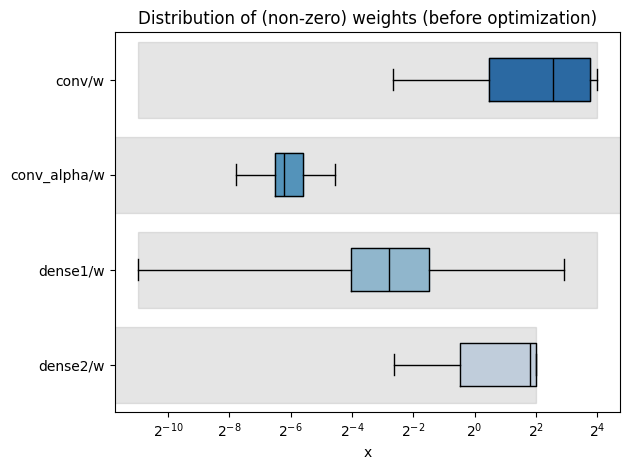

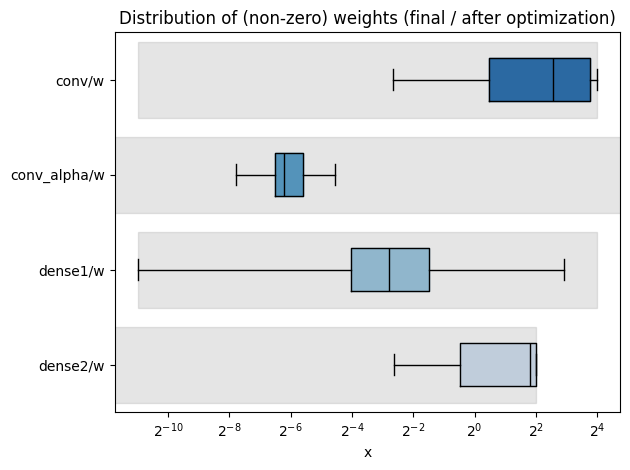

In [40]:
hls4ml.model.profiling.numerical(model=student_test, hls_model=hls_model)

In [41]:
print(hls4ml_trace)

{'conv': array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
      

In [42]:
layers = student_test.layers
conv_weights = student_test.layers[2].get_weights()
dense_weights = student_test.layers[5].get_weights()
qdensebatchnorm_weights = student_test.layers[7].get_weights()
print(layers)
print(conv_weights)
print(dense_weights)
print(qdensebatchnorm_weights)

[<keras.src.engine.input_layer.InputLayer object at 0x3121647c0>, <keras.src.layers.reshaping.reshape.Reshape object at 0x3138550f0>, <qkeras.qconvolutional.QConv2D object at 0x3138570d0>, <qkeras.qlayers.QActivation object at 0x31386c2e0>, <keras.src.layers.reshaping.flatten.Flatten object at 0x31386c670>, <qkeras.qlayers.QDense object at 0x31386ca30>, <qkeras.qlayers.QActivation object at 0x31381d8d0>, <qkeras.qlayers.QDense object at 0x31381c5b0>, <qkeras.qlayers.QActivation object at 0x30118e7a0>]
[array([[[[-0.01853696, -0.4556028 , -0.01853236, -0.00214724]],

        [[-0.03348652, -0.6814127 , -0.02758165, -0.05930248]]],


       [[[ 0.05850003, -0.05592623, -0.16580302, -0.21559009]],

        [[ 0.0729519 , -0.00956772, -0.21106008, -0.01473723]]]],
      dtype=float32)]
[array([[-0.63394785, -2.0444582 ,  0.28403428, ..., -0.61173326,
        -0.9624008 , -1.2063869 ],
       [ 0.27192667, -0.04630989, -0.00717268, ...,  0.1240128 ,
         0.34263298,  0.0468668 ],
      

In [43]:
#print(min(conv_weights))
conv_weights_list = []
for i in conv_weights[0][0][0][0]:
    conv_weights_list.append(i)
for j in conv_weights[0][1][0][0]:
    conv_weights_list.append(j)
print(min(conv_weights_list), max(conv_weights_list))

-0.4556028 0.058500033


In [40]:
print(min(dense_weights[0]), max(dense_weights[0]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

KeyError: 'XILINX_VIVADO'

In [30]:
hls4ml build -p complex_hls4mlproj

SyntaxError: invalid syntax (3971047448.py, line 1)

In [29]:
hls_model.build(csim=False, synth=True, vsynth=True)

Project myproject_prj does not exist. Rerun "hls4ml build -p complex_hls4mlproj".


sh: vivado_hls: command not found


In [ ]:
from pathlib import Path
import pprint

def getReports(indir):
    data_ = {}

    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))

    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))

        # Get the resources from the logic synthesis report
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut'] = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff'] = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp'] = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])

        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus'] = float(lat_line.split('|')[2]) * 5.0 / 1000.0
            data_['latency_ii'] = int(lat_line.split('|')[6])

    return data_

In [ ]:
data_quantized_pruned = getReports('complex_hls4mlproj')

print("\n Resource usage and latency: ")
pprint.pprint(data_quantized_pruned)